In [1]:
#### Written and Copyright by Mohit Agarwal, Ekansh Gupta
#### Georgia Institute of Technology
#### Email: magarwal37@gatech.edu, egupta8@gatech.edu

### Code to decode Error-Potentials for the data recording on any game
### Data should be present in the format of SXX-MMDD-XX.csv, _labels, and _metadata
### 16 Electrode Channels: desribed in metadata file e.g. ['Pz', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'Cz', 'Fz', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'Fpz']

### If want to classify data for every subject individually - put separate folder for every subject
### If training and testing on different files, the folder structure should be similar in both train and test

In [2]:
##Importing Libraries

import numpy as np
import os
import sys
import math
from pylab import *
# from random import shuffle
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
# from tabulate import tabulate
import csv
import pickle
# import pipeline
# import helper
# import plotting
import globals
# import predict
# import action_transfer
# import data_loader
# import data_loader_ssvep
# import data_loader_bci_ner
# import transfer_learning_test
# import train_test
import seaborn as sns
from pyriemann.utils.distance import distance_riemann
import pyriemann
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import ElasticNet, LogisticRegression, SGDClassifier
from sklearn.manifold import TSNE
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [3]:
def distance_riemann_array(A, B):
    A = np.reshape(A, (globals.covmat_dim,globals.covmat_dim))
    B = np.reshape(B, (globals.covmat_dim,globals.covmat_dim))
    return distance_riemann(A,B)

def plot_tSNE(covmats, Y):
    plt.figure()
    Y = np.array(Y)
    N = covmats.shape[0]
    D = covmats.shape[1]
    globals.covmat_dim = D
    covmats = np.reshape(covmats, (N,-1))
    tsne = TSNE(metric=distance_riemann_array, perplexity=50, learning_rate=200,early_exaggeration=4,\
                random_state=666, square_distances=True)
    X_embedded = tsne.fit_transform(covmats,Y)
    plt.scatter(X_embedded[Y==0,0],X_embedded[Y==0,1],label='Class-0')
    plt.scatter(X_embedded[Y==1,0],X_embedded[Y==1,1],label='Class-1')
    plt.legend(['Class-0' , 'Class-1'])
    plt.title("t-SNE plot with reimannian distance")
    plt.grid()
    plt.savefig('toy_tsne.pdf',bbox_inches='tight')
    plt.show()


def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 

def riemann_ner(X_train, Y_train):
    filt_1 = pyriemann.estimation.XdawnCovariances(nfilter=globals.xdawn_filters, applyfilters=True, \
                                                   estimator='lwf', xdawn_estimator='lwf')
    filt_2 = pyriemann.channelselection.ElectrodeSelection(nelec=globals.n_channel_select, metric='riemann')
    filt_3 = pyriemann.tangentspace.TangentSpace(metric='riemann', tsupdate=False) \
    # 36-sized vector for nelec=8
    filt_4 = Normalizer(norm='l1')
    filt_5 = ElasticNet(l1_ratio=0.05, alpha=0.02, normalize=True)
    train_data = []
    train_label = []
    cov_train = filt_1.fit_transform(X_train,Y_train)            #the data converted to covariance matrices
    return cov_train, Y_train

def generate_distance_list(cov_train, labels, num_pts):
    drift_list0 = [[] for i in range(num_pts)]
    drift_list1 = [[] for i in range(num_pts)]
    for i in range(2*num_pts):
        for j in range(i+1, 2*num_pts):
            pt_list=0
            td=0
            if i<num_pts and j<num_pts:
                pt_list=0
                td = (j-i)
            elif i>num_pts and j>num_pts:
                pt_list=0
                td = (j-i)
            else:
                pt_list=1
                td = j-i-num_pts
#             if td>num_pts-1:
#                 td = num_pts-1
            dist = distance_riemann(cov_train[i,:,:], cov_train[j,:,:])
            if pt_list==0:
                drift_list0[td].append(dist)
            else:
                drift_list1[td].append(dist)
    return drift_list0, drift_list1

def generate_dataframe(TD_array, drift_list0,drift_list1,drift_list_mean0,drift_list_mean1,\
                       time_interval,method="alt"):
    dataset_global=pd.DataFrame()
    axes_means = []
    if method=="alt":
        for j in TD_array:
            in_class_pts = np.array(drift_list0[j])
            cross_class_pts = np.array(drift_list1[j])
            in_class_pts = remove_outliers_gaussian(in_class_pts)
            cross_class_pts = remove_outliers_gaussian(cross_class_pts)
            pts = np.squeeze(np.concatenate((np.array(in_class_pts),np.array(cross_class_pts)),axis=0))
            label0 = \
            np.array(["Within class, \u0394T="+str(j*time_interval)+"s" for i in range(len(in_class_pts))])
            label1 = \
            np.array(["Cross class, \u0394T="+str(j*time_interval)+"s" for i in range(len(cross_class_pts))])
            labels = np.concatenate((label0,label1),axis=0) 
            index0 = np.array([0 for i in range(len(in_class_pts))])
            index1 = np.array([1 for i in range(len(cross_class_pts))])
            indices = np.concatenate((index0,index1),axis=0)
            dataset = pd.DataFrame(dict(pts=pts, labels=labels, indices=indices))
            dataset_global = pd.concat([dataset_global,dataset])
            axes_means.append(drift_list_mean0[j])
            axes_means.append(drift_list_mean1[j])
        
    else:
        axes_means0 = []
        axes_means1 = []
        in_class_global = []
        cross_class_global=[]
        in_class_labels = []
        cross_class_labels=[]
        in_class_indices = []
        cross_class_indices=[]
        for j in TD_array:
            in_class_pts = np.array(drift_list0[j])
            cross_class_pts = np.array(drift_list1[j])
            in_class_pts = remove_outliers_gaussian(in_class_pts)
            cross_class_pts = remove_outliers_gaussian(cross_class_pts)
            if len(in_class_global)==0:
                in_class_global = in_class_pts
                in_class_labels = \
                np.array(["WC, \u0394T="+str(j*time_interval)+"s" for i in range(len(in_class_pts))])
                in_class_indices = np.array([0 for i in range(len(in_class_pts))])
            else:
                in_class_global = np.concatenate((in_class_global, in_class_pts), axis=0)
                in_class_labels = np.concatenate((in_class_labels, \
                np.array(["WC, \u0394T="+str(j*time_interval)+"s" \
                          for i in range(len(in_class_pts))])))
                in_class_indices = np.concatenate((in_class_indices, \
                                                np.array([0 for i in range(len(in_class_pts))])))
                
            if len(cross_class_global)==0:
                cross_class_global = cross_class_pts
                cross_class_labels = np.array(["CC, \u0394T="+str(j*time_interval)+"s" for i in \
                                               range(len(cross_class_pts))])
                cross_class_indices = np.array([1 for i in range(len(cross_class_pts))])
            else:
                cross_class_global = np.concatenate((cross_class_global, cross_class_pts), axis=0)
                cross_class_labels = np.concatenate((cross_class_labels,\
                np.array(["CC, \u0394T="+str(j*time_interval)+"s"\
                          for i in range(len(cross_class_pts))])))
                cross_class_indices = np.concatenate((cross_class_indices,\
                                                     np.array([1 for i in range(len(cross_class_pts))])))
            axes_means0.append(drift_list_mean0[j])
            axes_means1.append(drift_list_mean1[j])
            
        pts = np.squeeze(np.concatenate((np.array(in_class_global),np.array(cross_class_global)),axis=0))
        labels = np.concatenate((in_class_labels,cross_class_labels),axis=0) 
        indices = np.concatenate((in_class_indices,cross_class_indices),axis=0)
        print(pts.shape)
        print(labels.shape)
        print(indices.shape)
        dataset_global = pd.DataFrame(dict(pts=pts, labels=labels, indices=indices))
        axes_means = np.concatenate((axes_means0, axes_means1),axis=0)
    return dataset_global,axes_means
        

def remove_outliers_gaussian(data):
    mean = np.mean(data)
    std = np.std(data)
    num_std=2.5
    ind_to_delete = []
    for i in range(data.shape[0]):
        if data[i] < mean-num_std*std or data[i]>mean+num_std*std:
            ind_to_delete.append(i) 
    print(str(len(ind_to_delete))+" outliers removed out of "+str(data.shape[0]))
    data = np.delete(data, ind_to_delete)
    return data
    
def seaborn_plot(TD_array,drift_list0,drift_list1,drift_list_mean0,drift_list_mean1, title, time_interval):
    dataset_global=pd.DataFrame()
    axes_means = []
    
    dataset_global,axes_means = generate_dataframe(TD_array, drift_list0,drift_list1,\
    drift_list_mean0,drift_list_mean1,time_interval, method="combine")


    # Initialize the FacetGrid object
    d = {'color': ['r', 'b']}
    sns.set_context("notebook", font_scale=2)
    pal = sns.cubehelix_palette(4, rot=0.5, light=.7)
    g = sns.FacetGrid(dataset_global, row="labels", hue="indices", aspect=15, height=1, palette=pal)
#     g.set(xlim=(1.5, 5.5))
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "pts",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "pts", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        label = x.iloc[0]
        ax.text(0, .2, label, fontweight="bold", color='black',
                ha="left", va="center", transform=ax.transAxes)
#         _ = plt.setp(ax.get_xticklabels(), visible=True)

    g.map(label, "labels")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=0, wspace=1)
    plt.suptitle(title)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set( ylabel="")
    g.despine(bottom=True, left=True, right=True, top=True, offset=0)
    g.set_xlabels(label="Drift (in units of Riemannian Distance)")
#     g.set_ylabels(label="KDE Density Distribution")
#     plt.setp(g._legend.get_title(), fontsize=20)
    i=0
    for ax in g.axes.ravel():
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        if i==4:
            ax.set_ylabel("KDE Density Distribution")
        i+=1
    i=0
    for a in g.axes.flatten():
#         a.set_xlim((2,9))
        a.axvline(axes_means[i], alpha=1, color='black', linestyle='--')
        i+=1
#     plt.savefig('Shin17_baseline_kde.pdf',bbox_inches='tight')


def generate_toy_dataset():
    time_interval=30
    title = 'KDE plots for relative drift vs time difference between samples'
    for key in globals.data_dict_1:
        [X,Y,c,d,n] = globals.data_dict_1[key]
    #     print(a.shape)
        idx_nonErrp = np.argwhere(Y==globals.stim_nonErrp)
        idx_Errp = np.argwhere(Y==globals.stim_Errp)
        sig_errp = np.squeeze(np.mean(X[idx_Errp[:],:,:],axis=0))
        sig_nonerrp = np.squeeze(np.mean(X[idx_nonErrp[:],:,:],axis=0))
        t = [(i*1.0)/globals.freq for i in range(X.shape[2])]
        plt.plot(t, sig_nonerrp[globals.channels.index("Fz")], color="red")
        plt.plot(t, sig_errp[globals.channels.index("Fz")], color="blue")
        plt.xlabel('time (s)')
        plt.ylabel('average signal template for one channel')
        plt.legend(['Class-1','Class-0']) #errp is class-0
        plt.title("Template signals chosen for the toy dataset classes")
        plt.grid()
        plt.savefig('toy_sig.pdf',bbox_inches='tight')
        plt.show()

        sig_class0 = np.zeros((num_pts, X.shape[1], X.shape[2]))
        sig_class1 = np.zeros((num_pts, X.shape[1], X.shape[2]))
        label_class0 = np.array([0 for i in range(num_pts)])
        label_class1 = np.array([1 for i in range(num_pts)])
        labels = np.concatenate((label_class0, label_class1), axis=0)

        for i in range(num_pts):
            sig_class0[i,:,:] = gaussian_noise(sig_errp, gauss_mean, gauss_std)
            sig_class1[i,:,:] = gaussian_noise(sig_nonerrp, gauss_mean, gauss_std)

        data = np.concatenate((sig_class0, sig_class1), axis=0)
    #     print(data.shape)
    #     print(labels.shape)

        cov_train, labels = riemann_ner(data, labels)
        plot_tSNE(cov_train, labels)
        drift_list0, drift_list1 = generate_distance_list(cov_train, labels, num_pts)
        drift_list_mean0 = [0 for i in range(num_pts)]
        drift_list_mean1 = [0 for i in range(num_pts)]
    #     drift_list_mean = [[[],[]] for i in range(2*num_pts)]
    #     for j in [2,5,10,20,50]:
    #         print(drift_list[j][0])
    #         print(drift_list[j][1])
        for j in range(num_pts-1):
            drift_list_mean0[j] = np.mean(drift_list0[j])
            drift_list_mean1[j] = np.mean(drift_list1[j])

        drift_list_mean0 = np.array(drift_list_mean0)
        drift_list_mean1 = np.array(drift_list_mean1)

        print("Results for the ADF for in-class and cross-class drift")
        result = adfuller(drift_list_mean0[2:-20])
        print(result)
        result = adfuller(drift_list_mean1[2:-20])
        print(result)
        print("Results for the KPSS for in-class and cross-class drift")
        result = kpss(drift_list_mean0[2:-20])
        print(result)
        result = kpss(drift_list_mean1[2:-20])
        print(result)
        
        td = [(i+1)*time_interval for i in range(num_pts)]
        plt.figure()
        plt.plot(td[1:-5], drift_list_mean0[1:-5], color="red",marker='o')
        plt.plot(td[1:-5], drift_list_mean1[1:-5], color="blue",marker='^')
#         plt.ylim((0.5,2.4))
        plt.xlabel('Time difference (s)')
        plt.ylabel('Average drift (units of Riemannian distance)')
        plt.legend(['In-class ','Cross-class']) #errp is class-0
        plt.title("Average drift vs time difference")
        plt.grid()
        plt.savefig('toy_avg.pdf',bbox_inches='tight')
        plt.show()
        
        seaborn_plot([3,6,9,12,15,18],drift_list0,drift_list1,drift_list_mean0,drift_list_mean1,title,30)
        
        break

def generate_plot_from_dataset(name1,name2,num_pts):
    time_interval=30
    title = 'KDE plots for relative drift vs time difference between samples'
    with open(name1, 'rb') as handle:
        dataset_dict_0 = pickle.load(handle)
    with open(name2, 'rb') as handle:
        dataset_dict_1 = pickle.load(handle)
#     keys = list(dataset_dict.keys())
#     keys.sort()
    drift_list0 = [[] for i in range(num_pts)]
    drift_list1 = [[] for i in range(num_pts)]
    drift_list_mean0 = [0 for i in range(num_pts)]
    drift_list_mean1 = [0 for i in range(num_pts)]
    for i in range(num_pts):
        drift_list0[i] = np.array(dataset_dict_0[i])
        drift_list1[i] = np.array(dataset_dict_1[i])
    for j in range(num_pts):
        drift_list_mean0[j] = np.mean(drift_list0[j])
        drift_list_mean1[j] = np.mean(drift_list1[j])
    td = [(i+1)*time_interval for i in range(num_pts)]
    plt.figure()
    plt.plot(td[2:-1], drift_list_mean0[2:-1], color="red",marker='o')
    plt.plot(td[2:-1], drift_list_mean1[2:-1], color="blue",marker='^')
#     plt.ylim((0.5,2.4))
    plt.xlabel('Time difference (s)')
    plt.ylabel('Average drift (units of Riemannian distance)')
    plt.legend(['In-class','Cross-class']) #errp is class-0
    plt.title("Average drift vs time difference")
    plt.grid()
#     plt.savefig('Shin17_baseline_avg.pdf',bbox_inches='tight')
    plt.show()
    
    print("Results for the ADF for in-class and cross-class drift")
    result = adfuller(drift_list_mean0[2:])
    print(result)
    result = adfuller(drift_list_mean1[2:])
    print(result)
    print("Results for the KPSS for in-class and cross-class drift")
    result = kpss(drift_list_mean0[2:])
    print(result)
    result = kpss(drift_list_mean1[2:])
    print(result)
    
    diff_idx0=1
    diff_idx1=6
    diff_idx2=11
    plt.figure()
    dlmd0_0 = [drift_list_mean0[i] - drift_list_mean0[i - diff_idx0] \
               for i, x in enumerate(drift_list_mean0) if i > diff_idx0-1][1:]
    dlmd0_1 = [drift_list_mean0[i] - drift_list_mean0[i - diff_idx1] \
               for i, x in enumerate(drift_list_mean0) if i > diff_idx1-1][1:]
    dlmd0_2 = [drift_list_mean0[i] - drift_list_mean0[i - diff_idx2] \
               for i, x in enumerate(drift_list_mean0) if i > diff_idx2-1][1:]
    dlmd1_0 = [drift_list_mean1[i] - drift_list_mean1[i - diff_idx0] \
               for i, x in enumerate(drift_list_mean1) if i > diff_idx0-1][1:]
    dlmd1_1 = [drift_list_mean1[i] - drift_list_mean1[i - diff_idx1] \
               for i, x in enumerate(drift_list_mean1) if i > diff_idx1-1][1:]
    dlmd1_2 = [drift_list_mean1[i] - drift_list_mean1[i - diff_idx2] \
               for i, x in enumerate(drift_list_mean1) if i > diff_idx2-1][1:]
    td0 = [(i+1)*time_interval for i in range(len(dlmd0_0))]
    td1 = [(i+1)*time_interval for i in range(len(dlmd0_1))]
    td2 = [(i+1)*time_interval for i in range(len(dlmd0_2))]
    plt.plot(td0, dlmd0_0, color="red",marker='o')
    plt.plot(td1, dlmd0_1, color="blue",marker='o')
    plt.plot(td2, dlmd0_2, color="green",marker='o')
    plt.plot(td0, dlmd1_0, color="red",marker='^')
    plt.plot(td1, dlmd1_1, color="blue",marker='^')
    plt.plot(td2, dlmd1_2, color="green",marker='^')
    plt.ylim((-0.2,1.2))
    plt.xlabel('Time difference (s)')
    plt.ylabel('\u0394Drift (units of Riemannian distance)')
    plt.legend(['In-class \u0394T=30s','In-class \u0394T=180s','In-class \u0394T=300s',\
                'Cross-class \u0394T=30s','Cross-class \u0394T=180s','Cross-class \u0394T=300s']) 
    plt.title("\u0394Drift as a function of time difference")
    plt.grid()
    plt.savefig('Shin17_mDA_delta_drift.pdf',bbox_inches='tight')
    plt.show()        
    
    seaborn_plot([3,6,9,12,15,18],drift_list0,drift_list1,drift_list_mean0,drift_list_mean1,\
                 title,time_interval)

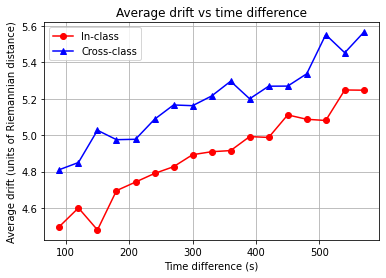

Results for the ADF for in-class and cross-class drift
(6.954356942966982, 1.0, 7, 10, {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}, -56.06843345708363)
(-1.204002962369283, 0.6718713724018476, 7, 10, {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}, -29.727095270741884)
Results for the KPSS for in-class and cross-class drift
(0.7032419096832084, 0.013250735483344687, 2, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.699948311262337, 0.013550153521605723, 2, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


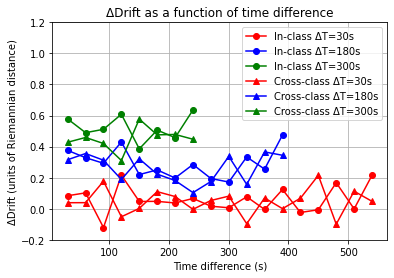

17 outliers removed out of 746
21 outliers removed out of 733
14 outliers removed out of 606
12 outliers removed out of 612
11 outliers removed out of 482
17 outliers removed out of 475
8 outliers removed out of 358
8 outliers removed out of 338
5 outliers removed out of 203
7 outliers removed out of 232
3 outliers removed out of 84
3 outliers removed out of 90
(4833,)
(4833,)
(4833,)


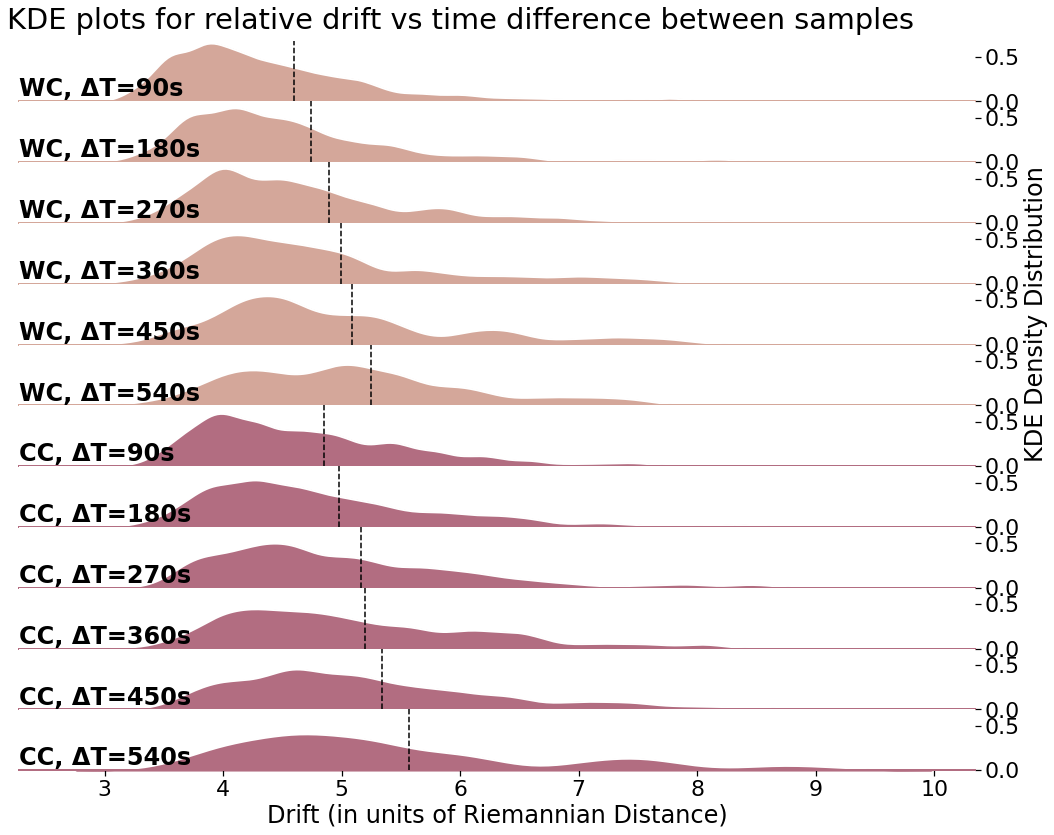

In [4]:
with open("errp1.5s_labData.pkl", 'rb') as handle:
    globals.data_dict_1 = pickle.load(handle)
num_pts = 100
gauss_mean = 0.0
gauss_std = 10
name1="Shin2017B_within.pkl"
name2="Shin2017B_cross.pkl"   
# generate_toy_dataset()
generate_plot_from_dataset(name1,name2,20)